In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [97]:
# Load the CSV file
df = pd.read_csv('combined_data.csv')
df.head(10)

,text,label
0,What is the Black-Scholes formula for European...,1
1,Explain the put-call parity relationship,1
2,How do you calculate the delta of an option?,1
3,What is implied volatility and how is it derived?,1
4,Describe the Greeks in options trading,1
5,What is the difference between American and Eu...,1
6,How does time decay affect option prices?,1
7,What is a butterfly spread strategy?,1
8,Explain the concept of gamma hedging,1
9,What is the binomial option pricing model?,1


In [98]:
# First split: 70% train, 30% temp (for val+test)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    random_state=RANDOM_SEED, 
    stratify=df['label']
)

# Second split: 15% val, 15% test (50-50 split of the 30%)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=RANDOM_SEED, 
    stratify=temp_df['label']
)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train size: 399 (70.0%)
Val size: 85 (14.9%)
Test size: 86 (15.1%)


In [99]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 399
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 85
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 86
    })
})

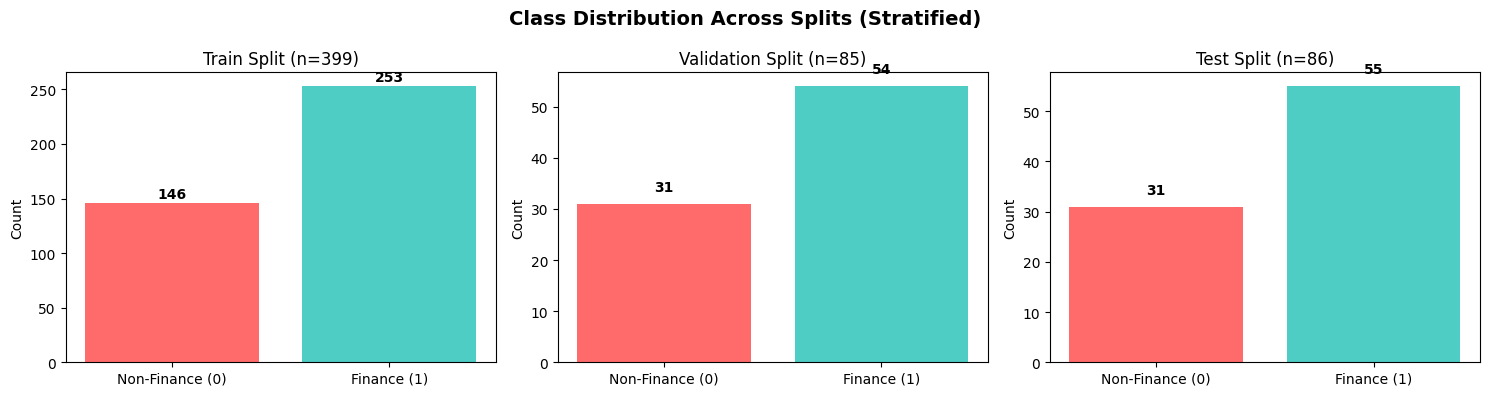

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

splits = [
    ('Train', train_df),
    ('Validation', val_df),
    ('Test', test_df)
]

colors = ['#ff6b6b', '#4ecdc4']  # Red for non-finance, teal for finance

for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['label'].value_counts().sort_index()
    bars = axes[idx].bar(['Non-Finance (0)', 'Finance (1)'], counts.values, color=colors)
    axes[idx].set_title(f'{split_name} Split (n={len(split_df)})')
    axes[idx].set_ylabel('Count')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts.values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                       str(count), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Class Distribution Across Splits (Stratified)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [101]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "answerdotai/ModernBERT-base"

# Label mappings matching the CSV structure
id2label = {0: "non_finance", 1: "finance"}
label2id = {"non_finance": 0, "finance": 1}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model.config

Loading weights: 100%|██████████| 136/136 [00:00<00:00, 1135.79it/s, Materializing param=model.layers.21.mlp_norm.weight]    
ModernBertForSequenceClassification LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     | 
------------------+------------+-
decoder.bias      | UNEXPECTED | 
classifier.bias   | MISSING    | 
classifier.weight | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


ModernBertConfig {
  "architectures": [
    "ModernBertForMaskedLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 50281,
  "classifier_activation": "gelu",
  "classifier_bias": false,
  "classifier_dropout": 0.0,
  "classifier_pooling": "mean",
  "cls_token_id": 50281,
  "decoder_bias": true,
  "deterministic_flash_attn": false,
  "dtype": "float32",
  "embedding_dropout": 0.0,
  "eos_token_id": 50282,
  "global_attn_every_n_layers": 3,
  "gradient_checkpointing": false,
  "hidden_activation": "gelu",
  "hidden_size": 768,
  "id2label": {
    "0": "non_finance",
    "1": "finance"
  },
  "initializer_cutoff_factor": 2.0,
  "initializer_range": 0.02,
  "intermediate_size": 1152,
  "label2id": {
    "finance": 1,
    "non_finance": 0
  },
  "layer_norm_eps": 1e-05,
  "layer_types": [
    "full_attention",
    "sliding_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "sliding_attention",
    "full_attention",
    "slid

In [102]:
# Freeze all base model parameters (train only classification head)
for param in model.model.parameters():
    param.requires_grad = False

# Verify: count trainable vs frozen parameters
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable: {trainable:,} | Frozen: {frozen:,}")

Trainable: 592,130 | Frozen: 149,014,272


In [103]:
from transformers import DataCollatorWithPadding

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

tokenized_dataset = dataset_dict.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_dataset

Map: 100%|██████████| 86/86 [00:00<00:00, 19078.13 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 399
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 85
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 86
    })
})

In [104]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.special import softmax

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = softmax(logits, axis=-1)
    confidence = np.max(probs, axis=-1)
    
    # Per-class metrics: [non_finance, finance]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    
    # Confidence stats
    correct_mask = preds == labels
    
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision_non_finance": precision[0],
        "recall_non_finance": recall[0],
        "f1_non_finance": f1[0],
        "precision_finance": precision[1],
        "recall_finance": recall[1],
        "f1_finance": f1[1],
        "confidence_mean": confidence.mean(),
        "confidence_correct": confidence[correct_mask].mean() if correct_mask.any() else 0.0,
        "confidence_wrong": confidence[~correct_mask].mean() if (~correct_mask).any() else 0.0,
    }

In [105]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./layer1_model",
    learning_rate=1e-3,
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_finance",
    greater_is_better=True,
    logging_steps=10,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [106]:
trainer.train()

/Users/isaacanwar/Desktop/Projects/poison-RAG-gaurdrail/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Non Finance,Recall Non Finance,F1 Non Finance,Precision Finance,Recall Finance,F1 Finance,Confidence Mean,Confidence Correct,Confidence Wrong
1,0.504139,0.408141,0.752941,0.916667,0.354839,0.511628,0.726027,0.981481,0.834646,0.831827,0.889478,0.656128
2,0.387605,0.271477,0.882353,0.862069,0.806452,0.833333,0.892857,0.925926,0.909091,0.888354,0.910078,0.725426
3,0.226592,0.297342,0.858824,0.913043,0.677419,0.777778,0.838710,0.962963,0.896552,0.909645,0.932707,0.769349
4,0.146597,0.357278,0.870588,0.884615,0.741935,0.807018,0.864407,0.944444,0.902655,0.925046,0.942836,0.805368
5,0.169766,0.284660,0.882353,0.888889,0.774194,0.827586,0.879310,0.944444,0.910714,0.937372,0.952998,0.820179
6,0.049004,0.272566,0.894118,0.892857,0.806452,0.847458,0.894737,0.944444,0.918919,0.939400,0.949902,0.850712
7,0.058282,0.430053,0.882353,0.920000,0.741935,0.821429,0.866667,0.962963,0.912281,0.947140,0.954781,0.889832
8,0.019937,0.339675,0.870588,0.857143,0.774194,0.813559,0.877193,0.925926,0.900901,0.953708,0.968572,0.853715
9,0.017381,0.416472,0.882353,0.888889,0.774194,0.827586,0.879310,0.944444,0.910714,0.963329,0.968113,0.927445


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
/Users/isaacanwar/Desktop/Projects/poison-RAG-gaurdrail/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]
/Users/isaacanwar/Desktop/Projects/poison-RAG-gaurdrail/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
/Users/isaacanwar/Desktop/Projects/poison-RAG-gaurdrail/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__i

TrainOutput(global_step=225, training_loss=0.1697758176922798, metrics={'train_runtime': 23.2179, 'train_samples_per_second': 257.775, 'train_steps_per_second': 16.151, 'total_flos': 50645800406796.0, 'train_loss': 0.1697758176922798, 'epoch': 9.0})

In [107]:
trainer.evaluate(tokenized_dataset["test"])

/Users/isaacanwar/Desktop/Projects/poison-RAG-gaurdrail/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.3300211727619171,
 'eval_accuracy': 0.8604651162790697,
 'eval_precision_non_finance': 0.8275862068965517,
 'eval_recall_non_finance': 0.7741935483870968,
 'eval_f1_non_finance': 0.8,
 'eval_precision_finance': 0.8771929824561403,
 'eval_recall_finance': 0.9090909090909091,
 'eval_f1_finance': 0.8928571428571429,
 'eval_confidence_mean': 0.9325406551361084,
 'eval_confidence_correct': 0.9514428973197937,
 'eval_confidence_wrong': 0.8159756660461426,
 'eval_runtime': 0.4175,
 'eval_samples_per_second': 206.007,
 'eval_steps_per_second': 7.186,
 'epoch': 9.0}